# Import Libaries and file csv
Import Libaries

In [ ]:
import pandas as pd 
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV 
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense,LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import math
import os.path
from os import path
from pylab import rcParams
from random import randrange
from pandas import Series
from matplotlib import pyplot
import pickle
import os
import joblib

Connected from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import CSV data file

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Dữ liệu Lịch sử VN Index.csv")
data

,Date,Close,Open,High,Low,Vol,% Change
0,2009-01-02,313.34,312.49,313.34,312.18,5.63K,-0.72%
1,2009-01-05,311.91,308.77,311.91,308.25,7.92K,-0.46%
2,2009-01-06,314.04,312.91,315.02,312.88,12.97K,0.68%
3,2009-01-07,319.58,320.40,322.59,319.29,14.75K,1.76%
4,2009-01-08,314.15,315.92,318.79,313.04,14.94K,-1.70%
...,...,...,...,...,...,...,...
3476,2022-12-06,1048.69,1093.67,1093.67,1048.69,1.48M,-4.11%
3477,2022-12-07,1041.02,1048.69,1059.79,1034.92,920.94K,-0.73%
3478,2022-12-08,1050.53,1041.02,1078.09,1041.02,916.99K,0.91%
3479,2022-12-09,1051.81,1050.53,1061.21,1041.39,788.20K,0.12%


#Prepare the Data

In [ ]:
data.Date = pd.to_datetime(data.Date, dayfirst = False)
data.set_index("Date", inplace = True)

In [ ]:
data = data[['Close']] # Just use the close price
data

,Close
Date,
2009-01-02,313.34
2009-01-05,311.91
2009-01-06,314.04
2009-01-07,319.58
2009-01-08,314.15
...,...
2022-12-06,1048.69
2022-12-07,1041.02
2022-12-08,1050.53


In [ ]:
data.index

DatetimeIndex(['2009-01-02', '2009-01-05', '2009-01-06', '2009-01-07',
               '2009-01-08', '2009-01-09', '2009-01-12', '2009-01-13',
               '2009-01-14', '2009-01-15',
               ...
               '2022-11-29', '2022-11-30', '2022-12-01', '2022-12-02',
               '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08',
               '2022-12-09', '2022-12-12'],
              dtype='datetime64[ns]', name='Date', length=3481, freq=None)

In [ ]:
data.describe()

,Close
count,3481.000000
mean,731.448383
std,306.115564
min,235.500000
25%,491.040000
50%,605.080000
75%,961.780000
max,1528.570000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3481 entries, 2009-01-02 to 2022-12-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3481 non-null   float64
dtypes: float64(1)
memory usage: 54.4 KB


In [ ]:
data.count() 

Close    3481
dtype: int64

Display Close Price into 2 plot below

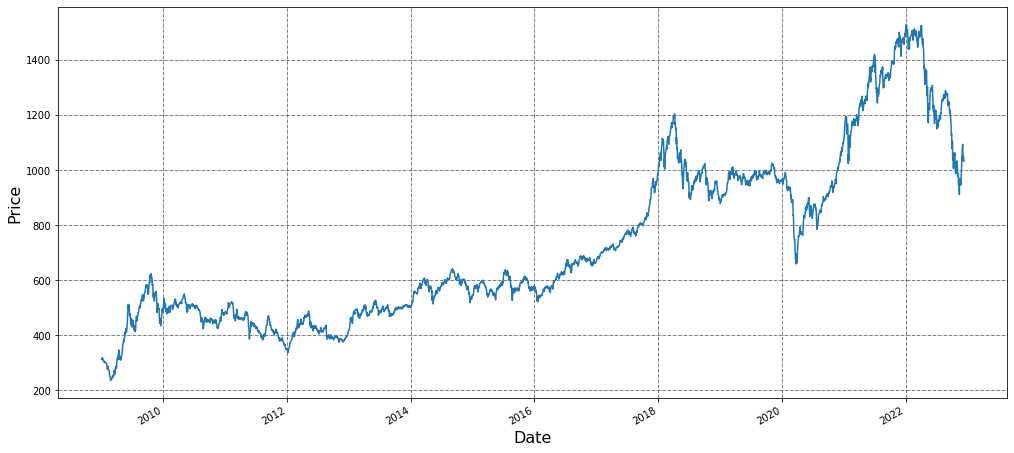

In [ ]:
import matplotlib.ticker as ticker

data['Close'].plot(figsize=(17, 8))

plt.ylabel('Price', fontsize=16)
plt.xlabel('Date', fontsize=16)

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

plt.show()

#Test-Train split
We need to split the data into two set of data: training data and testing data
Using eighty percent of data for training and the remaining twenty percent for testing. This 80/20 split is the most common approach 


In [ ]:
size_train = int(len(data)*0.80) 
train_data = data[0:size_train] 
test_data = data[size_train:]

In [ ]:
pd_train = pd.DataFrame(train_data['Close']) 
pd_test = pd.DataFrame(test_data['Close'])
print("Tập train:")
print(pd_train.describe())
print("") 
print("Tập test:")
print(pd_test.describe())

Tập train:
             Close
count  2784.000000
mean    622.874131
std     211.935501
min     235.500000
25%     470.660000
50%     565.345000
75%     738.360000
max    1204.330000

Tập test:
             Close
count   697.000000
mean   1165.122296
std     231.159789
min     659.210000
25%     947.240000
50%    1195.530000
75%    1351.170000
max    1528.570000


Display the training-set and the testing set as plot

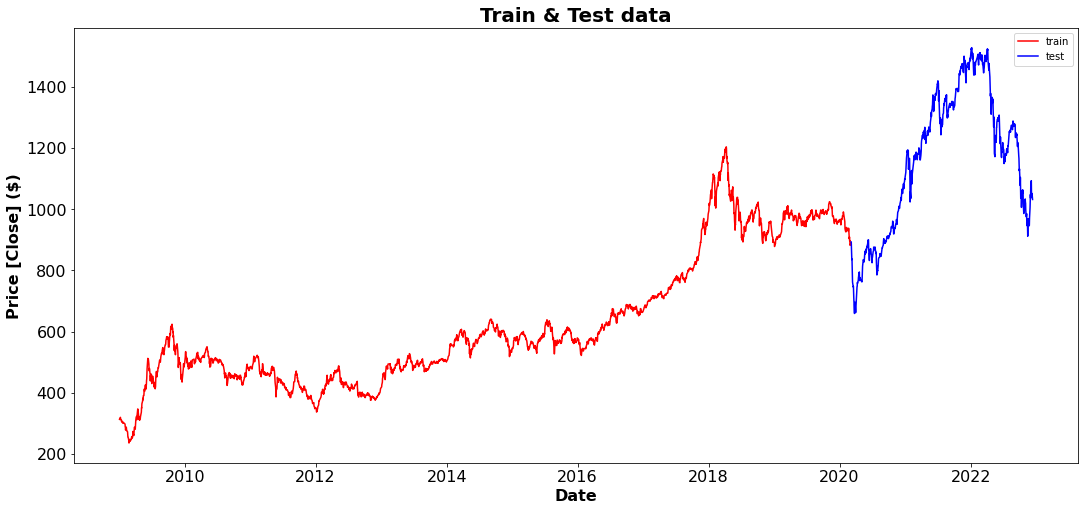

In [ ]:
fig, ax = plt.subplots(figsize=(18,8)) # 4.5, 2
sns.lineplot(x = data.index[:size_train], y = data['Close'][:size_train], color = 'red')
sns.lineplot(x = data.index[size_train:], y = data['Close'][size_train:], color = 'blue')
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price [Close] ($)', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

Create x_train, y_train, x_test, y_test

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 30
X_train, y_train = create_dataset(train_data['Close'], time_step)
X_test, y_test = create_dataset(test_data['Close'], time_step)


Create a copy variables for review the model

In [ ]:
X_train_copy = X_train
y_train_copy = y_train
X_test_copy = X_test
y_test_copy = y_test

Normalize data

In [ ]:
scaler_test = MinMaxScaler(feature_range=(0,1))
scaler_train = MinMaxScaler(feature_range=(0,1))

X_train = scaler_train.fit_transform(X_train)
X_test  = scaler_test.fit_transform(X_test)
y_train = scaler_train.fit_transform(y_train.reshape(-1,1))
y_test = scaler_test.fit_transform(y_test.reshape(-1,1))

#Building the model


####Long Short Term Memory Model

In [ ]:
hidden_nodes = 20

model_LSTM = Sequential()
model_LSTM.add(LSTM(hidden_nodes, activation="relu", recurrent_dropout=0.1, return_sequences = True, input_shape = (X_train.shape[1],1)))
model_LSTM.add(LSTM(hidden_nodes, return_sequences =False))
model_LSTM.add(Dense(20))
model_LSTM.add(Dense(1))
model_LSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')

model_LSTM.fit(X_train,y_train, epochs= 100, batch_size= 26)

Epoch 1/100
106/106 [==============================] - 8s 34ms/step - loss: 0.0274
Epoch 2/100
106/106 [==============================] - 4s 33ms/step - loss: 5.4858e-04
Epoch 3/100
106/106 [==============================] - 4s 34ms/step - loss: 4.8636e-04
Epoch 4/100
106/106 [==============================] - 4s 33ms/step - loss: 4.4735e-04
Epoch 5/100
106/106 [==============================] - 3s 33ms/step - loss: 4.2301e-04
Epoch 6/100
106/106 [==============================] - 3s 32ms/step - loss: 4.0389e-04
Epoch 7/100
106/106 [==============================] - 3s 32ms/step - loss: 3.4980e-04
Epoch 8/100
106/106 [==============================] - 4s 33ms/step - loss: 3.5344e-04
Epoch 9/100
106/106 [==============================] - 3s 33ms/step - loss: 3.3868e-04
Epoch 10/100
106/106 [==============================] - 4s 42ms/step - loss: 3.1764e-04
Epoch 11/100
106/106 [==============================] - 4s 36ms/step - loss: 3.1808e-04
Epoch 12/100
106/106 [=======================

#Predict on test data and visualize 

In [ ]:
y_pred_test_LSTM = model_LSTM.predict(X_test)


21/21 [==============================] - 1s 7ms/step


In [ ]:
y_pred_test_LSTM = scaler_test.inverse_transform(y_pred_test_LSTM.reshape(-1,1))

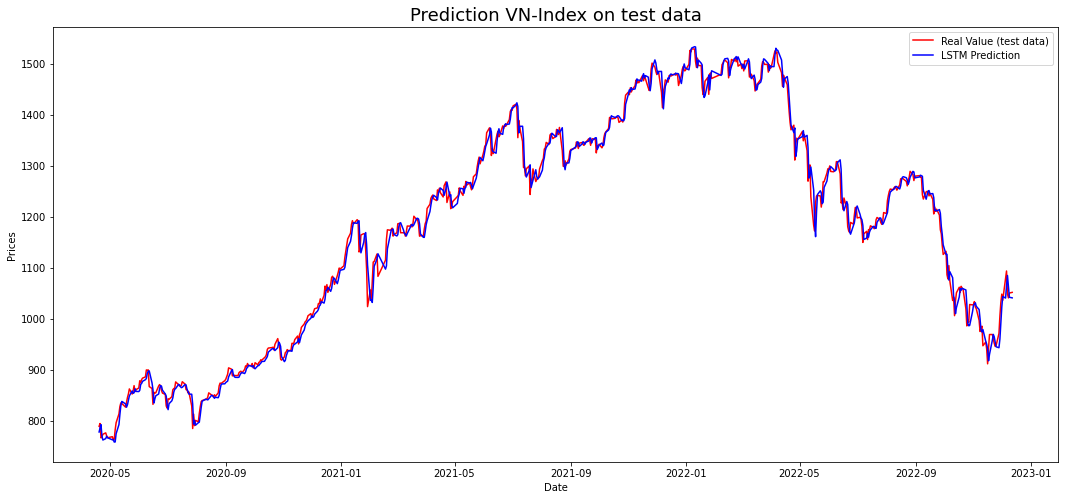

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(data.index[2815:], y_test_copy, color="red", label=f"Real Value (test data)")
plt.plot(data.index[2815:], y_pred_test_LSTM, color="blue", label = 'LSTM Prediction')
plt.title('Prediction VN-Index on test data', fontsize=18)
plt.xlabel('Date')
plt.ylabel("Prices")
plt.legend()

#Visualize train data

In [ ]:
y_pred_train_LSTM = model_LSTM.predict(X_train) 

87/87 [==============================] - 1s 7ms/step


In [ ]:
y_pred_train_LSTM = scaler_train.inverse_transform(y_pred_train_LSTM.reshape(-1,1))

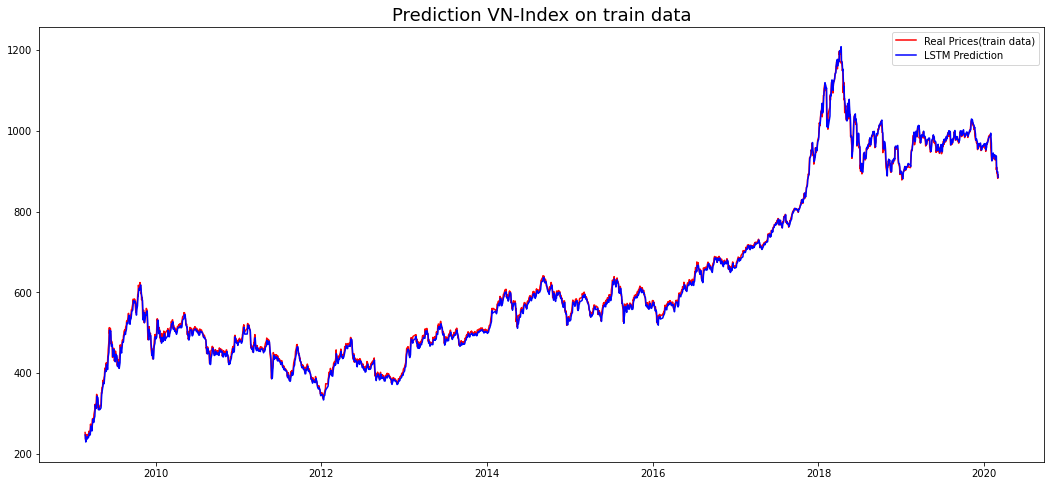

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(data.index[31:2784],y_train_copy, color="red", label = 'Real Prices(train data)')
plt.plot(data.index[31:2784],y_pred_train_LSTM, color="blue", label = 'LSTM Prediction')
plt.title('Prediction VN-Index on train data', fontsize=18)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.legend()

#Review model

In [ ]:
print("TẬP TEST                           TẬP TRAIN")
print("LSTM")
print("MSE  : " + str(mean_squared_error(y_test_copy, y_pred_test_LSTM))                
+"  ||  "  + str(mean_squared_error(y_train_copy, y_pred_train_LSTM)))
print("MAE  : " + str(mean_absolute_error(y_test_copy, y_pred_test_LSTM))               
+"  ||  " + str(mean_absolute_error(y_train_copy, y_pred_train_LSTM)))
print("MAPE : " + str(mean_absolute_percentage_error(y_test_copy, y_pred_test_LSTM)*100)
+" ||  "  + str(mean_absolute_percentage_error(y_train_copy, y_pred_train_LSTM)*100))
print("R2   : " + str(round(metrics.r2_score(y_test_copy, y_pred_test_LSTM), 15))
+"  ||  "  + str(round(metrics.r2_score(y_train_copy, y_pred_train_LSTM), 15)))

TẬP TEST                           TẬP TRAIN
LSTM
MSE  : 297.2702827284123  ||  77.31429119574783
MAE  : 12.262866955089855  ||  6.64306239451316
MAPE : 1.0626334047331205 ||  1.1663717821998618
R2   : 0.993733459339718  ||  0.998250149532741


#Predicting index in next 30 days

In [ ]:
x_input=test_data[667:].values.reshape(1, -1)
x_input.shape

(1, 30)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
lst_output=[]
n_steps=30
i=0
while(i<30):
    
    if(len(temp_input)>30):
        #(temp_input)
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #(x_input)
        yhat = model_LSTM.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_LSTM.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1


In [ ]:
Prediction_LSTM = scaler_test.inverse_transform(lst_output)

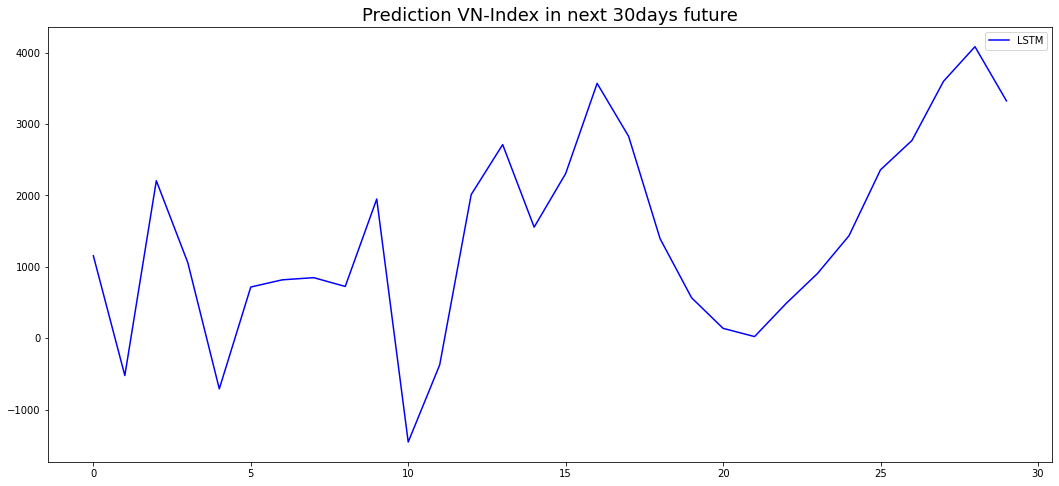

In [ ]:
plt.figure(figsize= (18, 8))
plt.plot(Prediction_LSTM,color='blue', label ="LSTM")
plt.title('Prediction VN-Index in next 30days future', fontsize=18)
plt.legend()